In [38]:
# remember to put this line in your notebook, otherwise the visualization won't show up
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.5f}'.format

Populating the interactive namespace from numpy and matplotlib


**Instructions**

Prepare your data: This includes loading the data you are using into a dataframe and generate a dataframe that holds the information you need to produce the graph. For example, if you are plotting averages of your variable of interest you first have to calculate that average.

Create the plot: This includes making a decision about what kind of plot to create, setting up the code, and the schema, plotting the actual plot, and then customize it. Customizing should include adjusting, margins, title, labels, tick marks, grids, color, font size, legend, annotation, source, etc. Anything that makes the plot easier to read and interesting for the reader. You want to revisit the slide from the lecture on how to design nice graphs. 

Save and show plot: Save the graph as pdf or png file and upload this file together with your notebook to NYU classes. Make sure that your code is executable. Will will deduct points if the code does not produce the graph uploaded to NYU classes.
We will grade the visualization according to the following criteria:

Data prep for the graph (3 points): Describe what you are plotting and how this relates to your research question. In case you need to prepare variables before plotting the code needs to be understandable

Graph (5 points): Did you choose the right plot to visualize your relationship of interest? Is the graph visually appealing? Does it give the right information to the reader? Is it easy to understand? Are all axis labeled? Is the source mentioned?

Save and show graph (2 points): Save graph as png and upload to NYU classes, and show the graph in the notebook.

In [28]:
#Aggregated Grant Fund Data at the Congressional District Label per Year 
fedrep = pd.read_csv('../final/data/fedReporter_sum.csv',)
print(len(fedrep), "records"); fedrep.head()

3629 records


,CONGRESSIONAL_DISTRICT,ORGANIZATION_STATE,DEPARTMENT,AGENCY,FY,FY_TOTAL_COST,CD
0,0,AK,NSF,NSF,2010,51603573.00000,AK-AL
1,0,AS,NSF,NSF,2010,25504.00000,AS-AL
2,0,CA,NSF,NSF,2010,1733993.00000,CA-AL
3,0,CO,NSF,NSF,2010,19500.00000,CO-AL
4,0,CT,NSF,NSF,2010,2547090.00000,CT-AL


In [29]:
#Lets pivot to make each fiscal year a column 
nsf_funding = pd.pivot_table(fedrep[['CD', 'FY','FY_TOTAL_COST']], values = 'FY_TOTAL_COST', index=['CD'], 
                             columns = 'FY').reset_index()

nsf_funding.fillna(0, inplace=True) # Fill nulls with zeros

print("CDs with NSF Funding: ",len(nsf_funding))
nsf_funding.head()

CDs with NSF Funding:  496


FY,CD,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AK-AL,51603573.00000,22687709.00000,22539453.00000,18967382.00000,20995436.00000,13296918.00000,14825962.00000,25180562.00000,28372191.00000
1,AL-01,1491436.00000,2094388.00000,812058.00000,2951772.00000,2258434.00000,2580521.00000,1620257.00000,2424339.00000,2815529.00000
2,AL-02,191663.00000,698822.00000,1664756.00000,0.00000,1564887.00000,737822.00000,475136.00000,2286960.00000,1124906.00000
3,AL-03,11416358.00000,17828995.00000,5335738.00000,8842962.00000,7510531.00000,5526549.00000,16313640.00000,13572790.00000,14050883.00000
4,AL-04,1713314.00000,0.00000,0.00000,1037202.00000,179999.00000,795529.00000,0.00000,0.00000,0.00000


In [30]:
# We need to normalize the data before we can do clustering
nsf_funding_norm = preprocessing.normalize(nsf_funding.iloc[:,1:])

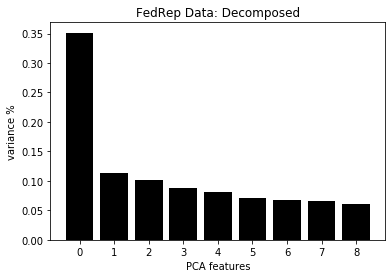

In [31]:
# Let's do PCA so we can visualize it in 2-D
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(nsf_funding_norm)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.title("FedRep Data: Decomposed")
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

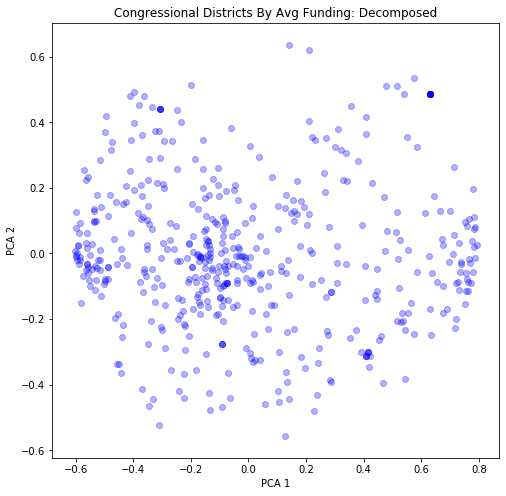

In [32]:
# Let's visualize the Federal Reporter data
plt.figure(figsize=(8,8))
plt.title("Congressional Districts By Avg Funding: Decomposed")
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [33]:
#Some helper functions for running clustering

#This runs Kmeans with the given data and number of clusters 
def get_kmeans_labels(input_data, n_clusters):
    km = KMeans(random_state = 2019, n_clusters = n_clusters)
    km.fit(input_data)
    res = km.predict(input_data)
    return res

#This finds and keeps the best cluster number and the corresponding cluster labeling  
def find_best_cluster(max_clusters, input_data, labels_func):
    best_cluster = 0
    best_avg = -1
    best_labels = []
    for n_clusters in range(2, max_clusters+1):
        cluster_labels = labels_func(input_data, n_clusters)
        silhouette_avg = silhouette_score(input_data, cluster_labels)
        if silhouette_avg >= best_avg:
            best_avg = silhouette_avg
            best_cluster = n_clusters
            best_labels = cluster_labels
    return {'cluster_num': best_cluster, 'labels': best_labels, 'score': best_avg}

#This just gives a count of elements within each cluster
def describe_labels(labels, score, title):
    if score:
        print(title+" Clusters: {}, Score: {}".format(len(np.unique(labels)), score))
    else: 
        print(title+" Clusters: {}".format(len(np.unique(labels))))
    for cluster in np.unique(labels):
        print("Cluster {}, Size: {}".format(cluster, (labels == cluster).sum()))
    print()


In [34]:
#Helper functions for visualizing data

#This averages the received funding per year in each cluster 
def visualize_avgs(input_data, labels, title=None):
    plt.figure(figsize=(8,8))
    if title:
        plt.title(title)
    for cluster in np.unique(labels):
        temp = input_data[labels == cluster].mean()
        std  = input_data[labels == cluster].std()
        plt.plot(temp.index, temp.values, label = cluster)
         
    plt.legend(np.unique(labels), title='Cluster#')
    plt.xlabel('Fiscal Year')
    plt.ylabel('Avg Total Received Funding')
    plt.show() 

#This colors the PCA plot given each points cluster label
def visualize_pca(pca_data, labels, title=None):
    plt.figure(figsize=(8,8))
    if title:
        plt.title(title)
    for i in np.unique(labels):    
        tmp = PCA_components[ labels == i]
        plt.scatter(tmp[0], tmp[1], alpha=.4)
    plt.legend(np.unique(labels), title='Cluster#')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.show() 


In [35]:
#Here we are running Kmeans Clustering
# with different cluster numbers
# But we are going to keep the best cluster number
# i.e. the cluster number with the best silhouette score
kmean_cluster_info = find_best_cluster(10, nsf_funding_norm, get_kmeans_labels)
describe_labels(kmean_cluster_info['labels'], kmean_cluster_info['score'], "KMeans")
labels_kmeans = kmean_cluster_info['labels']

KMeans Clusters: 2, Score: 0.27237290943827813
Cluster 0, Size: 167
Cluster 1, Size: 329



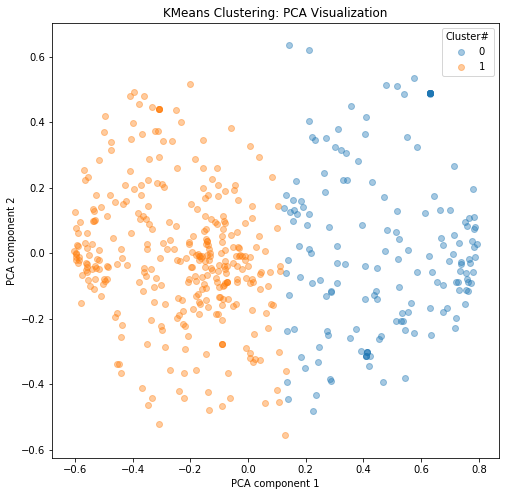

In [39]:
#Visualize how each point got clustered 
#Visually check how good the clustering worked out
visualize_pca(PCA_components, labels_kmeans, "KMeans Clustering: PCA Visualization")

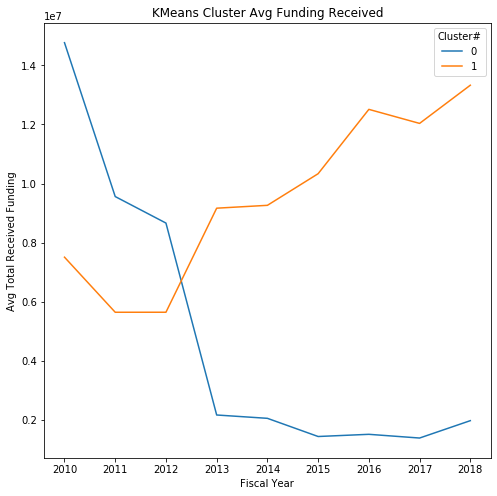

In [37]:
#Visualize how each cluster's average received compares 
# We want to see if there are noticeable differences in funding between clusters 
#  As we can see:
#    Cluster 0 has a decrease in funding 
#    Cluster 1 has a steady climb in received funding
visualize_avgs(nsf_funding, labels_kmeans, "KMeans Cluster Avg Funding Received")

In [40]:
# We will go into deeper analysis in the presentation and final memo